In [2]:
global center_lat, center_lon, center_heading



center_lat = 40.75794805357645
center_lon = -73.98553867868135
center_heading = 204.501


In [3]:
import numpy as np
import skimage as sk
import skimage.io as skio
import json
import copy
import triangle
import matplotlib.pyplot as plt
import skimage as ski
from PIL import Image
import imageio
import os
from tqdm import tqdm
import cv2
from scipy import signal
import copy
import open3d as o3d

In [4]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    radius_of_earth = 6371 * 1000  # Radius of Earth in kilometers. Use 3959 for miles.

    # Calculate the distance
    distance = radius_of_earth * c

    return distance

In [6]:
class Scene():
    def __init__(self, img_path, depth_path):
#         self.depth = skio.imread(depth_path)
#         self.depth = sk.img_as_float(self.depth)[:,:,0]
        data_array = np.genfromtxt(depth_path, delimiter=',', dtype=float)
        self.depth = data_array
        self.colors = skio.imread(img_path)
        self.colors = sk.img_as_float(self.colors)[:,:,:3]
        self.points = []
        self.w = self.colors.shape[1]
        self.h = self.colors.shape[0]
        self.selected_index  = []
        self.displacement = np.array([0,0,0])
        self.rotation_matrix = None
        img_path_split = img_path[:-4].split("_")
        self.lat = float(img_path_split[0])
        self.lon = float(img_path_split[1])
#         print(img_path_split)
        self.heading = float(img_path_split[2])
    
    def calculate_initial_compass_bearing(self, lat1, lon1, lat2, lon2):
        """
        Calculates the initial compass bearing between two points.

        Parameters:
        - lat1, lon1: Latitude and longitude of the starting point (in degrees)
        - lat2, lon2: Latitude and longitude of the destination point (in degrees)

        Returns:
        - Initial compass bearing in degrees (from 0 to 360)
        """

        # Convert latitude and longitude from degrees to radians
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

        # Calculate the differences in longitude
        d_lon = lon2 - lon1

        # Calculate the initial bearing using atan2
        x = np.sin(d_lon) * np.cos(lat2)
        y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(d_lon))
        

        initial_bearing = atan2(x, y)

        # Convert the initial bearing from radians to degrees
        initial_bearing = initial_bearing/3.14159 * 180

        # Normalize the initial bearing to the range [0, 360)
        initial_bearing = (initial_bearing + 360) % 360

        return initial_bearing
    
    
    def calcualte_displacement(self, lat1=center_lat, lon1=center_lon,heading1=center_heading):
            lat2 = self.lat
            lon2 = self.lon
            heading2 = self.heading
            
            
            dheading = self.calculate_initial_compass_bearing(lat1, lon1, lat2, lon2)
            
            # Convert latitude and longitude from degrees to radians
            lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

            # Haversine formula
            dlat = lat2 - lat1
            dlon = lon2 - lon1
            a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
            c = 2 * atan2(sqrt(a), sqrt(1 - a))
            radius_of_earth = 6371 * 1000  # Radius of Earth in kilometers. Use 3959 for miles.

            # Calculate the distance
            distance = radius_of_earth * c
            print('distance', distance)

            
            print('dheading', dheading)
            print('heading2', heading2)
            dheading = dheading/180 * 3.14159
            heading2 = heading2/180*3.14159

            
            rotation_matrix = np.array([[np.cos(heading2),-np.sin(heading2),0],
                           [np.sin(heading2),np.cos(heading2),0],
                           [0,0,1]])

            self.rotation_matrix = rotation_matrix
            self.displacement = [-np.cos(dheading)*distance, np.sin(dheading)*distance, 0]
#             self.displacement = [np.sin(dheading)*distance, np.cos(dheading)*distance, 0]    

    
#     for offset_i in np.linspace(0, 1, 5):
#     for offset_j in np.linspace(0, 1, 5):
#         phi = (w-(j+offset_j)-1)/(w-1) * 2* 3.14159 + 0.5*3.14159
#         theta = (h-(i+offset_i)-1)/(h-1) * 3.14159
    
    def calculate_xyz_coordinate_populate(self):
        self.calcualte_displacement()
        total_count = 0
        for i in range(self.h):
            for j in range(self.w):
                if self.depth[i,j] < 1e7:
                    for offset_i in [0, 0.33,0.66]:
                        for offset_j in [0, 0.33,0.66]:
                            phi = (1-(self.w-(j+offset_j)-1)/(self.w-1)) * 2* 3.14159 - 3.14159
                            theta = (self.h-(i+offset_i)-1)/(self.h-1) * 3.14159

    #                         phi = (1-(self.w-j-1)/(self.w-1)) * 2* 3.14159 - 3.14159
    #                         theta = (self.h-i-1)/(self.h-1) * 3.14159
                            v = np.array([-np.sin(theta)*np.cos(phi), -np.sin(theta)*np.sin(phi), np.cos(theta)])

            #                 if total_count == 39596:
            #                     print(v,self.depth[i,j])
                            v = v @ self.rotation_matrix
            #                     if total_count == 39596:
            #                         print(copy.copy(v*self.depth[i,j])
                            self.points.append(copy.copy(v*self.depth[i,j]) + self.displacement)
                            self.selected_index.append(i*self.w + j)
                total_count+=1
    
    def calculate_xyz_coordinate(self):
        self.calcualte_displacement()
        total_count = 0
        for i in range(self.h):
            for j in range(self.w):
                if self.depth[i,j] < 1e7:
                    phi = (1-(self.w-j-1)/(self.w-1)) * 2* 3.14159 - 3.14159
                    theta = (self.h-i-1)/(self.h-1) * 3.14159

#                         phi = (1-(self.w-j-1)/(self.w-1)) * 2* 3.14159 - 3.14159
#                         theta = (self.h-i-1)/(self.h-1) * 3.14159
                    v = np.array([-np.sin(theta)*np.cos(phi), -np.sin(theta)*np.sin(phi), np.cos(theta)])

    #                 if total_count == 39596:
    #                     print(v,self.depth[i,j])
                    v = v @ self.rotation_matrix
    #                     if total_count == 39596:
    #                         print(copy.copy(v*self.depth[i,j])
                    self.points.append(copy.copy(v*self.depth[i,j]) + self.displacement)
                    self.selected_index.append(i*self.w + j)
                total_count+=1
    

In [7]:
im_dir = './'
images = []
img_paths = []
# iterate over images in the directory
for f in os.scandir(im_dir):
    if f.is_file() and f.name.lower().endswith('.png'):
        img_paths.append(f.path[2:])

depth_paths = []

for i in range(len(img_paths)):
    temp = img_paths[i][:-4].split("_")
    temp = "_".join(temp) + ".csv"
    depth_paths.append(temp)
depth_paths = depth_paths[1:3]
img_paths = img_paths[1:3]
print(img_paths)
print(depth_paths)

['40.75828229336389_-73.98533018890905_209.31956.png', '40.75843655632809_-73.98522007034872_207.89609.png']
['40.75828229336389_-73.98533018890905_209.31956.csv', '40.75843655632809_-73.98522007034872_207.89609.csv']


In [8]:
scenes = []
for img_path, depth_path in zip(img_paths, depth_paths):
    temp = Scene(img_path, depth_path)
    scenes.append(copy.deepcopy(temp))

In [9]:
for scene in scenes:
    scene.calculate_xyz_coordinate()

distance 41.105536619699436
dheading 25.290263661772315
heading2 209.31956
distance 60.58627576750001
dheading 26.290838007633
heading2 207.89609


In [10]:
points = []
colors = None

for scene in scenes:
    temp_points = scene.points

    points += temp_points
    temp_colors = scene.colors
    temp_colors = temp_colors.reshape(-1,3)
    temp_colors = temp_colors[scene.selected_index]

    if colors is None:
        colors = temp_colors
    else:
        colors =  np.concatenate((colors, temp_colors),axis=0)

points = np.array(points)
print(points.shape)
print(colors.shape)

(176460, 3)
(176460, 3)


In [ ]:
points = np.array(points)
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(points)
point_cloud.colors = o3d.utility.Vector3dVector(colors)
o3d.visualization.draw_geometries([point_cloud])

2023-12-07 10:04:10.817 python[95958:15808307] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit


# Try SIFT feature matching

In [11]:
im1 = plt.imread(img_paths[0])
im2 = plt.imread(img_paths[1])

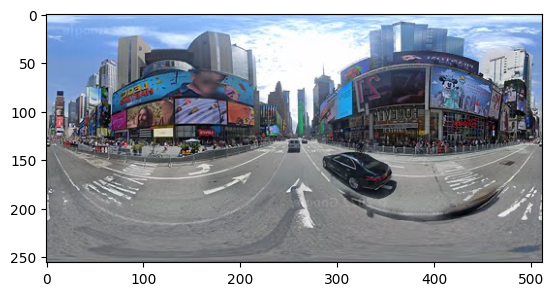

In [12]:
plt.imshow(im1)

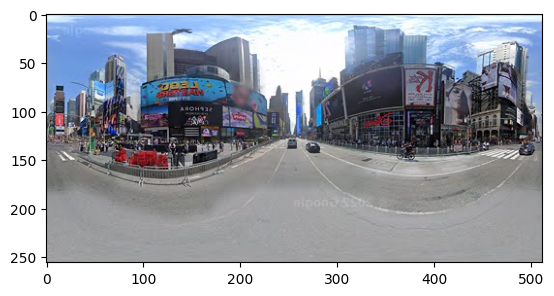

In [13]:
plt.imshow(im2)

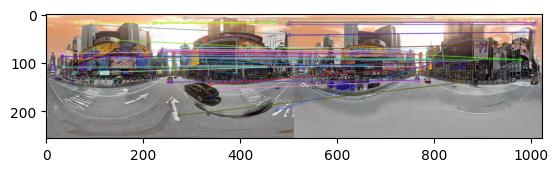

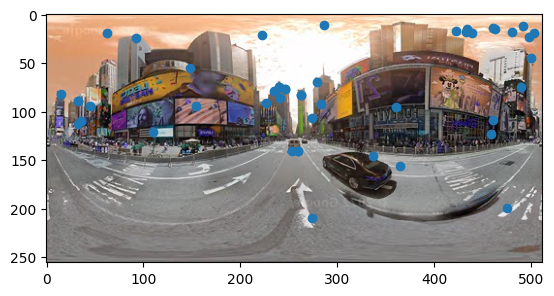

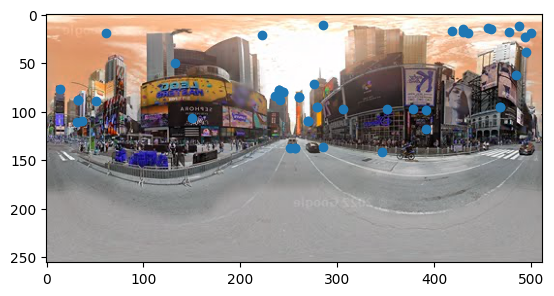

In [14]:
# Read the two images
image1 = cv2.imread((img_paths[0]), cv2.IMREAD_COLOR)
image2 = cv2.imread((img_paths[1]), cv2.IMREAD_COLOR)

# Convert images to grayscale
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# Initialize the SIFT detector
sift = cv2.SIFT_create()

# Detect SIFT keypoints and compute descriptors for both images
keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

# Create a Brute Force Matcher object
bf = cv2.BFMatcher()

# Match SIFT descriptors between the two images
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# Apply ratio test to get good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Extract matched keypoints
matched_keypoints1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
matched_keypoints2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])

# Draw matches on the images
matching_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matching image
# cv2.imshow("SIFT Feature Matches", matching_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
plt.imshow(matching_image)
plt.show()

# Create an image with matched keypoints
matched_image1 = cv2.drawKeypoints(image1, keypoints1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
matched_image2 = cv2.drawKeypoints(image2, keypoints2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display the images with matched keypoints
plt.imshow(image1)
plt.plot(matched_keypoints1[:, 0], matched_keypoints1[:, 1], 'o')
plt.show()
plt.imshow(image2)
plt.plot(matched_keypoints2[:, 0], matched_keypoints2[:, 1], 'o')
plt.show()
# cv2.imshow("Image 1 with Matched Keypoints", matched_image1)
# cv2.imshow("Image 2 with Matched Keypoints", matched_image2)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [18]:
# self.calcualte_displacement()
# total_count = 0
# for i in range(self.h):
#     for j in range(self.w):
#         if self.depth[i,j] < 1e7:
#             phi = (1-(self.w-j-1)/(self.w-1)) * 2* 3.14159 - 3.14159
#             theta = (self.h-i-1)/(self.h-1) * 3.14159

#             v = np.array([-np.sin(theta)*np.cos(phi), -np.sin(theta)*np.sin(phi), np.cos(theta)])

#             v = v @ self.rotation_matrix

#             self.points.append(copy.copy(v*self.depth[i,j]) + self.displacement)
#             self.selected_index.append(i*self.w + j)
#         total_count+=1

def im2pts(depth, points_2d):
    points_3d = []
    h, w = depth.shape

    for i in range(points_2d.shape[0]):
        point = points_2d[i]
        r, c = point
        phi = (1-(w-c-1)/(w-1)) * 2* 3.14159 - 3.14159
        theta = (h-r-1)/(h-1) * 3.14159
        
        v = np.array([-np.sin(theta)*np.cos(phi), -np.sin(theta)*np.sin(phi), np.cos(theta)])

        i, j = int(r), int(c)
        if depth[i,j] < 1e7:
            points_3d.append(copy.copy(v*depth[i,j]*255))
        else:
            points_3d.append(np.zeros(3))
            
    return np.array(points_3d)

In [19]:
depth1 = np.genfromtxt(depth_paths[0], delimiter=',', dtype=float)
depth2 = np.genfromtxt(depth_paths[1], delimiter=',', dtype=float)

In [105]:
points3d1 = im2pts(depth1, matched_keypoints1[:, ::-1])
points3d2 = im2pts(depth2, matched_keypoints2[:, ::-1])

In [106]:
temp = np.array([3, 4, 9, 10])
non_zero_indices = np.where((points3d1 != [0, 0, 0]).all(axis=1) & (points3d2 != [0, 0, 0]).all(axis=1))[0][temp]

In [108]:
points3d1 = points3d1[non_zero_indices]
points3d2 = points3d2[non_zero_indices]

In [ ]:
3, 4, 8, 9, 10

IndexError: index 6 is out of bounds for axis 0 with size 6

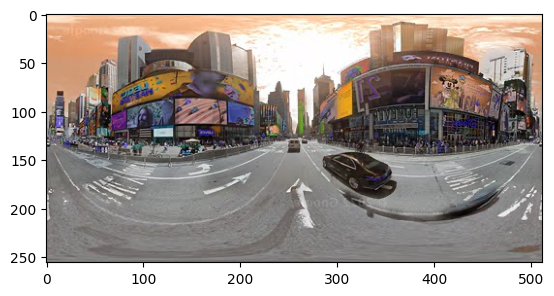

In [103]:
idx = 6
plt.imshow(image1)
plt.plot(matched_keypoints1[non_zero_indices][idx, 0], matched_keypoints1[non_zero_indices][idx, 1], 'rx')
plt.show()
plt.imshow(image2)
plt.plot(matched_keypoints2[non_zero_indices][idx, 0], matched_keypoints2[non_zero_indices][idx, 1], 'rx')
plt.show()

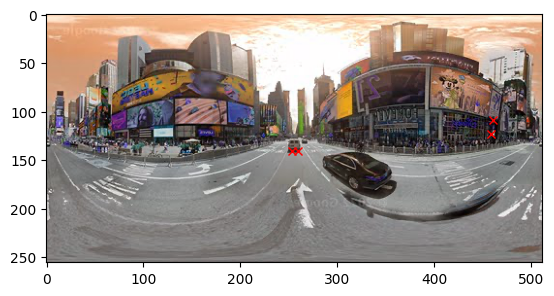

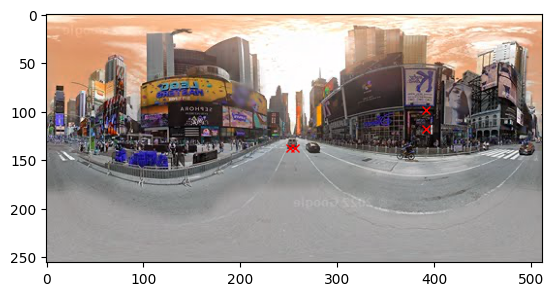

In [107]:
plt.imshow(image1)
plt.plot(matched_keypoints1[non_zero_indices][:, 0], matched_keypoints1[non_zero_indices][:, 1], 'rx')
plt.show()
plt.imshow(image2)
plt.plot(matched_keypoints2[non_zero_indices][:, 0], matched_keypoints2[non_zero_indices][:, 1], 'rx')
plt.show()

In [24]:
def umeyama(P, Q):
    assert P.shape == Q.shape
    n, dim = P.shape

    centeredP = P - P.mean(axis=0)
    centeredQ = Q - Q.mean(axis=0)

    C = np.dot(np.transpose(centeredP), centeredQ) / n

    V, S, W = np.linalg.svd(C)
    d = (np.linalg.det(V) * np.linalg.det(W)) < 0.0

    if d:
        S[-1] = -S[-1]
        V[:, -1] = -V[:, -1]

    R = np.dot(V, W)

    varP = np.var(P, axis=0).sum()
    c = 1/varP * np.sum(S) # scale factor

    t = Q.mean(axis=0) - P.mean(axis=0).dot(c*R)

    return c, R, t

In [115]:
c, R, t = umeyama(points3d1, points3d2)

In [109]:
points3d1.shape

(4, 3)

In [166]:
from scipy.optimize import least_squares

def residuals(params, src_pts, tgt_pts):
    theta, tx, ty = params
    x = src_pts[:, 0]
    y = src_pts[:, 1]
    z = src_pts[:, 2]
    trans_x = np.cos(theta) * x + np.sin(theta) * y + tx
    trans_y = -np.sin(theta) * x + np.cos(theta) * y + ty
    trans_z = z
    
    trans_pts = np.column_stack([trans_x, trans_y])
    residuals = (trans_pts - tgt_pts[:, :2]).flatten()
    
    return residuals

params = np.random.random(3)
result = least_squares(residuals, params, args=(points3d1, points3d2))
print(result)

theta, tx, ty = result.x
transformation = np.array([[np.cos(theta),np.sin(theta),tx],
                           [-np.sin(theta),np.cos(theta),ty],
                           [0,0,0]])

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-9.626e+02  7.468e+02 -1.213e+03  8.483e+02  9.821e+02
               -7.865e+02  1.194e+03 -8.087e+02]
           x: [ 2.420e-01 -2.158e+03  9.598e+01]
        cost: 3669065.345350949
         jac: [[ 8.840e+02  1.000e+00  0.000e+00]
               [ 3.160e+03 -0.000e+00  1.000e+00]
               ...
               [-4.298e+03  1.000e+00  0.000e+00]
               [-3.708e+03 -0.000e+00  1.000e+00]]
        grad: [ 5.870e+02 -1.859e-07 -6.911e-04]
  optimality: 586.9700390379876
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 20
        njev: 20


In [167]:
R

array([[ 0.96918518, -0.22261315, -0.10546784],
       [ 0.21716626,  0.97424362, -0.06073046],
       [ 0.11627077,  0.03595501,  0.99256654]])

In [168]:
transformation

array([[ 9.70866464e-01,  2.39621178e-01, -2.15751598e+03],
       [-2.39621178e-01,  9.70866464e-01,  9.59790428e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [ ]:
def calculate_xyz_coordinate(self):
        self.calcualte_displacement()
        total_count = 0
        for i in range(self.h):
            for j in range(self.w):
                if self.depth[i,j] < 1e7:
                    phi = (1-(self.w-j-1)/(self.w-1)) * 2* 3.14159 - 3.14159
                    theta = (self.h-i-1)/(self.h-1) * 3.14159

#                         phi = (1-(self.w-j-1)/(self.w-1)) * 2* 3.14159 - 3.14159
#                         theta = (self.h-i-1)/(self.h-1) * 3.14159
                    v = np.array([-np.sin(theta)*np.cos(phi), -np.sin(theta)*np.sin(phi), np.cos(theta)])

    #                 if total_count == 39596:
    #                     print(v,self.depth[i,j])
                    v = v @ self.rotation_matrix
    #                     if total_count == 39596:
    #                         print(copy.copy(v*self.depth[i,j])
                    self.points.append(copy.copy(v*self.depth[i,j]) + self.displacement)
                    self.selected_index.append(i*self.w + j)
                total_count+=1

In [26]:
def calculate_cart_coordinate(depth, rgb):
    points = []
    colors = []
    h, w = depth.shape
    for i in range(h):
        for j in range(w):
            phi = (1-(w-j-1)/(w-1)) * 2* 3.14159 - 3.14159
            theta = (h-i-1)/(h-1) * 3.14159
            
            v = np.array([-np.sin(theta)*np.cos(phi), -np.sin(theta)*np.sin(phi), np.cos(theta)])

            if depth[i,j] < 1e7:
                points.append(copy.copy(v*depth[i,j]*255))
                colors.append(rgb[i, j])
                
    return np.array(points), np.array(colors)

In [177]:
pcd1, colors1 = calculate_cart_coordinate(depth1, im1[:, :, :3])
pcd2, colors2 = calculate_cart_coordinate(depth2, im2[:, :, :3])

In [175]:
pcd1 = pcd1 @ R + t
# colors1 = colors1 * 0 + np.array([255, 0, 0])

In [170]:
pcd1

array([[   268.67045838,  -5822.83692491, -12269.33811768],
       [   269.27249488,  -5835.88473219, -11915.83751487],
       [   350.65102286,  -5997.06250684, -12252.81140194],
       ...,
       [     0.        ,     -0.        ,    569.72568154],
       [     0.        ,     -0.        ,    569.72507358],
       [     0.        ,     -0.        ,    569.72452641]])

In [178]:
pcd1 = pcd1 @ transformation

In [179]:
pcd1

array([[    1656.11817915,    -5588.81796501, -1138531.12123668],
       [    1659.82920715,    -5601.34138283, -1141082.34065929],
       [    1777.45849904,    -5738.3234603 , -1332127.50358614],
       ...,
       [       0.        ,        0.        ,        0.        ],
       [       0.        ,        0.        ,        0.        ],
       [       0.        ,        0.        ,        0.        ]])

In [176]:
pcd1

array([[ -4559.50871612,  -6610.28995805, -11942.97515583],
       [ -4520.65698665,  -6610.4256056 , -11591.37338019],
       [ -4515.96871237,  -6797.68385231, -11924.63680385],
       ...,
       [ -2062.56853574,   -415.99004852,    475.36254599],
       [ -2062.56860642,   -415.99007038,    475.36194254],
       [ -2062.56867004,   -415.99009005,    475.36139944]])

In [173]:
points = np.concatenate([pcd1, pcd2], axis=0)
colors = np.concatenate([colors1, colors2], axis=0)
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(points)
point_cloud.colors = o3d.utility.Vector3dVector(colors)
flip_z_matrix = np.array([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, -1.0, 0.0], [0.0, 0.0, 0.0, 1.0]], dtype=np.float64)
point_cloud.transform(flip_z_matrix)
o3d.visualization.draw_geometries([point_cloud])

In [165]:
points = pcd1
colors = colors1
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(points)
point_cloud.colors = o3d.utility.Vector3dVector(colors)
o3d.visualization.draw_geometries([point_cloud])

# Try Open3D global registration

In [141]:
def preprocess_point_cloud(pcd, voxel_size):
    print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = pcd.voxel_down_sample(voxel_size)

    radius_normal = voxel_size * 2
    print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = voxel_size * 5
    print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh

In [142]:
pcd1, colors1 = calculate_cart_coordinate(depth1, im1[:, :, :3])
pcd2, colors2 = calculate_cart_coordinate(depth2, im2[:, :, :3])

In [143]:

point_cloud1 = o3d.geometry.PointCloud()
point_cloud1.points = o3d.utility.Vector3dVector(pcd1)
point_cloud1.colors = o3d.utility.Vector3dVector(colors1)

point_cloud2 = o3d.geometry.PointCloud()
point_cloud2.points = o3d.utility.Vector3dVector(pcd2)
point_cloud2.colors = o3d.utility.Vector3dVector(colors2)

In [144]:
voxel_size = 0.5
source_down, source_fpfh = preprocess_point_cloud(point_cloud1, voxel_size)
target_down, target_fpfh = preprocess_point_cloud(point_cloud2, voxel_size)

:: Downsample with a voxel size 0.100.
:: Estimate normal with search radius 0.200.
:: Compute FPFH feature with search radius 0.500.
:: Downsample with a voxel size 0.100.
:: Estimate normal with search radius 0.200.
:: Compute FPFH feature with search radius 0.500.


In [45]:
o3d.visualization.draw_geometries([source_down])

In [145]:
def execute_global_registration(source_down, target_down, source_fpfh,
                                target_fpfh, voxel_size):
    distance_threshold = voxel_size * 1.5
    print(":: RANSAC registration on downsampled point clouds.")
    print("   Since the downsampling voxel size is %.3f," % voxel_size)
    print("   we use a liberal distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh, True,
        distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        3, [
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(
                0.9),
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(
                distance_threshold)
        ], o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999))
    return result

In [146]:
result_ransac = execute_global_registration(source_down, target_down,
                                            source_fpfh, target_fpfh,
                                            voxel_size)
print(result_ransac)

:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.100,
   we use a liberal distance threshold 0.150.
RegistrationResult with fitness=2.751577e-03, inlier_rmse=9.143536e-02, and correspondence_set size of 243
Access transformation to get result.


In [147]:
def draw_registration_result(source, target, transformation, show_diff=True):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    
    if show_diff:
        source_temp.paint_uniform_color([1, 0.706, 0])
        target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp],
                                      zoom=0.4559,
                                      front=[0.6452, -0.3036, -0.7011],
                                      lookat=[1.9892, 2.0208, 1.8945],
                                      up=[-0.2779, -0.9482, 0.1556])

In [148]:
draw_registration_result(point_cloud1, point_cloud2, result_ransac.transformation)

In [149]:
def refine_registration(source, target, source_fpfh, target_fpfh, voxel_size):
    distance_threshold = voxel_size * 0.4
    print(":: Point-to-plane ICP registration is applied on original point")
    print("   clouds to refine the alignment. This time we use a strict")
    print("   distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_icp(
        source, target, distance_threshold, result_ransac.transformation,
        o3d.pipelines.registration.TransformationEstimationPointToPlane())
    return result

In [150]:
point_cloud1.estimate_normals()
point_cloud2.estimate_normals()
result_icp = refine_registration(point_cloud1, point_cloud2, source_fpfh, target_fpfh,
                                 voxel_size)
print(result_icp)
draw_registration_result(point_cloud1, point_cloud2, result_icp.transformation)

:: Point-to-plane ICP registration is applied on original point
   clouds to refine the alignment. This time we use a strict
   distance threshold 0.040.
RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.
